Hello, friends! I'm trying to see here a simple linear model for predicting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list 
# the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

sample_submission.csv
test.csv
train.csv



Let's see what we have...

In [2]:
#    Get the train data set: train_df
train = pd.read_csv("../input/train.csv")
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [3]:
def conf_int_duration(df):
    """ Drop off the outliers of trip_duration"""
    
    conf_int_duration = np.percentile(df.trip_duration, [5.0,95.0])
    print('\nConfidental interval trip_duration: {}'.format(conf_int_duration))
    
    df.loc[df.trip_duration <= conf_int_duration[0],'trip_duration'] = np.nan
    value=df.trip_duration.min()
    df.trip_duration.fillna(value=value, inplace=True) 
    
    df.loc[df.trip_duration >= conf_int_duration[1],'trip_duration'] = np.nan
    value=df.trip_duration.max()
    df.trip_duration.fillna(value=value, inplace=True)
    
    print("Trip_duration describe past drop:\n",df.trip_duration.describe())
    
    return

In [4]:
### Change the data of trip_duration by fuction conf_int_duration(df):
conf_int_duration(train) 


Confidental interval trip_duration: [  180.  2104.]
Trip_duration describe past drop:
 count    1.458644e+06
mean     8.043713e+02
std      5.267916e+02
min      1.810000e+02
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      2.103000e+03
Name: trip_duration, dtype: float64


In [5]:
print("\n train.info():\n{}".format(train.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null float64
dtypes: float64(5), int64(2), object(4)
memory usage: 122.4+ MB

 train.info():
None


In [6]:
#    Get the test data set: test_df
test = pd.read_csv("../input/test.csv", index_col='id')
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 625134 entries, id3004672 to id0621643
Data columns (total 8 columns):
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(2)
memory usage: 42.9+ MB


To process the same fields, combine two tables

In [7]:
result = pd.concat([train, test])
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2083778 entries, 0 to id0621643
Data columns (total 11 columns):
dropoff_datetime      object
dropoff_latitude      float64
dropoff_longitude     float64
id                    object
passenger_count       int64
pickup_datetime       object
pickup_latitude       float64
pickup_longitude      float64
store_and_fwd_flag    object
trip_duration         float64
vendor_id             int64
dtypes: float64(5), int64(2), object(4)
memory usage: 190.8+ MB


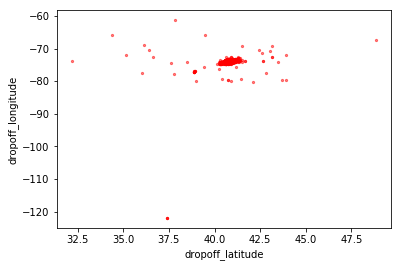

In [8]:
result.plot(x='dropoff_latitude', y='dropoff_longitude', 
            kind='scatter', marker='.', alpha=0.5, c='r')

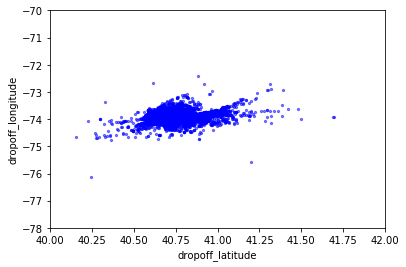

In [9]:
result.plot(x='dropoff_latitude', y='dropoff_longitude', 
            xlim=(40.0, 42.0), ylim=(-78.0, -70.0), 
            kind='scatter', marker='.', alpha=0.5, c='b')

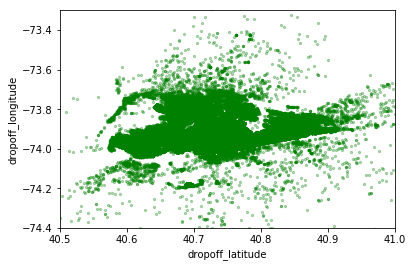

In [10]:
result.plot(x='dropoff_latitude', y='dropoff_longitude',
            xlim=(40.5, 41.0), ylim=(-74.4, -73.3), 
            kind='scatter', marker='.', alpha=0.3, c='g')

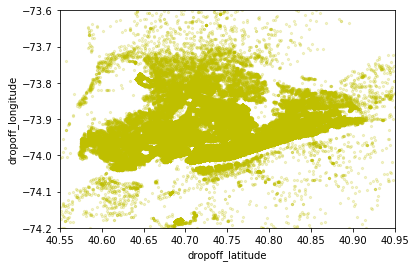

In [11]:
result.plot(x='dropoff_latitude', y='dropoff_longitude',
            xlim=(40.55, 40.95), ylim=(-74.2, -73.6), 
            kind='scatter', marker='.', alpha=0.2, c='y')

In [12]:
def conf_int_coordinates(df):
    df['pickup_longitude'] = df.pickup_longitude.round(4)
    df['pickup_latitude'] = df.pickup_latitude.round(4)
    df.loc[:,['pickup_longitude', 'pickup_latitude']].describe()
    
    ###  Get data coordinates only in confidence interval pickup_Latitude:
    conf_int_latit = np.percentile(df.pickup_latitude, [2.5, 97.5])
    print(conf_int_latit)
    
    df.loc[df.pickup_latitude <= conf_int_latit[0], 'pickup_latitude'] = np.nan
    value=df.pickup_latitude.min()
    df.pickup_latitude.fillna(value=value, inplace=True)
    
    df.loc[df.pickup_latitude >= conf_int_latit[1], 'pickup_latitude'] = np.nan
    value=df.pickup_latitude.max()
    df.pickup_latitude.fillna(value=value, inplace=True)
    
    ###  Get data coordinates only in confidence interval pickup_longitude:
    conf_int_longit = np.percentile(df.pickup_longitude,  [2.5, 97.5])
    print(conf_int_longit)
    
    df.loc[df.pickup_longitude <= conf_int_longit[0], 'pickup_longitude'] = np.nan
    value=df.pickup_longitude.min()
    df.pickup_longitude.fillna(value=value, inplace=True)
    
    df.loc[df.pickup_longitude >= conf_int_longit[1], 'pickup_longitude'] = np.nan
    value=df.pickup_longitude.max()
    df.pickup_longitude.fillna(value=value, inplace=True)
    
    df['dropoff_longitude'] = df.dropoff_longitude.round(4)
    df['dropoff_latitude'] = df.dropoff_latitude.round(4)
    df.loc[:,['pickup_longitude', 'pickup_latitude']].describe()
    
    ###  Get data coordinates only in confidence interval dropoff_latitude:
    conf_int_latit = np.percentile(df.dropoff_latitude,  [2.5,97.5])
    print(conf_int_latit)
    
    df.loc[df.dropoff_latitude <= conf_int_latit[0], 'dropoff_latitude'] = np.nan
    value=df.dropoff_latitude.min()
    df.dropoff_latitude.fillna(value=value, inplace=True)
    
    df.loc[df.dropoff_latitude >= conf_int_latit[1], 'dropoff_latitude'] = np.nan
    value=df.dropoff_latitude.max()
    df.dropoff_latitude.fillna(value=value, inplace=True)
    
    ###  Get data coordinates only in confidence interval dropoff_longitude
    conf_int_longit = np.percentile(df.dropoff_longitude,  [2.5,97.5])
    print(conf_int_longit)
    
    df.loc[df.dropoff_longitude <= conf_int_longit[0], 'dropoff_longitude'] = np.nan
    value=df.dropoff_longitude.min()
    df.dropoff_longitude.fillna(value=value, inplace=True)
    
    df.loc[df.dropoff_longitude >= conf_int_longit[1], 'dropoff_longitude'] = np.nan
    value=df.dropoff_longitude.max()
    df.dropoff_longitude.fillna(value=value, inplace=True)
    
    print(df.describe())
    return

In [13]:
conf_int_coordinates(result)

[ 40.6774  40.7968]
[-74.0098 -73.8628]
[ 40.6763  40.8095]
[-74.0111 -73.8705]
       dropoff_latitude  dropoff_longitude  passenger_count  pickup_latitude  \
count      2.083778e+06       2.083778e+06     2.083778e+06     2.083778e+06   
mean       4.075180e+01      -7.397422e+01     1.663700e+00     4.075137e+01   
std        2.820045e-02       2.789893e-02     1.313358e+00     2.477628e-02   
min        4.067640e+01      -7.401100e+01     0.000000e+00     4.067750e+01   
25%        4.073590e+01      -7.399130e+01     1.000000e+00     4.073740e+01   
50%        4.075450e+01      -7.397980e+01     1.000000e+00     4.075410e+01   
75%        4.076980e+01      -7.396300e+01     2.000000e+00     4.076840e+01   
max        4.080940e+01      -7.387060e+01     9.000000e+00     4.079670e+01   

       pickup_longitude  trip_duration     vendor_id  
count      2.083778e+06   1.458644e+06  2.083778e+06  
mean      -7.397513e+01   8.043713e+02  1.534930e+00  
std        3.004794e-02   5.267916

In [14]:
print("\nresult.info():\n{}".format(result.info()))

<class 'pandas.core.frame.DataFrame'>
Index: 2083778 entries, 0 to id0621643
Data columns (total 11 columns):
dropoff_datetime      object
dropoff_latitude      float64
dropoff_longitude     float64
id                    object
passenger_count       int64
pickup_datetime       object
pickup_latitude       float64
pickup_longitude      float64
store_and_fwd_flag    object
trip_duration         float64
vendor_id             int64
dtypes: float64(5), int64(2), object(4)
memory usage: 190.8+ MB

result.info():
None


In [15]:
#	Distance of route
AVG_EARTH_RADIUS = 6371  # in km
def haversine(df, miles=True):
    """ Get the distance of routes by  the haversinus formula"""
    lat1, lng1, lat2, lng2 = (df.pickup_latitude[:], 
                              df.pickup_longitude[:], 
                              df.dropoff_latitude[:], 
                              df.dropoff_longitude[:])
    # convert all latitudes/longitudes from decimal degrees to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # calculate haversine
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat*0.5)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng*0.5)**2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    if miles:
        df['trip_distance'] = h * 0.621371  # in miles
        df['trip_distance'] = df.trip_distance.round(2)
        print(df.trip_distance.describe())
        return 
    else:
        df['trip_distance'] = h  # in kilometers
        df['trip_distance'] = df.trip_distance.round(2)
        print(df.trip_distance.describe())
        return

In [16]:
haversine(result, miles=True) 

count    2.083778e+06
mean     1.913214e+00
std      1.776777e+00
min      0.000000e+00
25%      7.600000e-01
50%      1.280000e+00
75%      2.350000e+00
max      1.196000e+01
Name: trip_distance, dtype: float64


In [17]:
def conf_int_distance(df):
    """ Drop off values of distance by confidantal interval"""
    conf_int_distance = np.percentile(df.trip_distance, [5.0,100.0])
    print('\nConfidental interval trip_duration: {}'.format(conf_int_distance))
    df.loc[df.trip_distance <= conf_int_distance[0],'trip_distance'] = np.nan
    value=df.trip_distance.min() 
    df.trip_distance.fillna(value=value, inplace=True)     
    df.loc[df.trip_distance >= conf_int_distance[1],'trip_distance'] = np.nan
    value=df.trip_distance.max()
    df.trip_distance.fillna(value=value, inplace=True)
    print("\nTrip_distance describe:\n",df.trip_distance.describe())
    return

In [18]:
conf_int_distance(result)


Confidental interval trip_duration: [  0.37  11.96]

Trip_distance describe:
 count    2.083778e+06
mean     1.920555e+00
std      1.769919e+00
min      3.800000e-01
25%      7.600000e-01
50%      1.280000e+00
75%      2.350000e+00
max      1.193000e+01
Name: trip_distance, dtype: float64


In [19]:
def arrays_bearing(df):
    """ Get azimuth between points pickup and dropoff"""
    lats1, lngs1, lats2, lngs2 = (df['pickup_latitude'][:], 
                                  df['pickup_longitude'][:], 
                                  df['dropoff_latitude'][:], 
                                  df['dropoff_longitude'][:])
    lats1_rads = np.radians(lats1)
    lats2_rads = np.radians(lats2)
    lngs_delta_rads = np.radians(lngs2 - lngs1)
    
    y = np.sin(lngs_delta_rads) * np.cos(lats2_rads)
    x = np.cos(lats1_rads) * np.sin(lats2_rads) -                      \
    np.sin(lats1_rads) * np.cos(lats2_rads) * np.cos(lngs_delta_rads)
    df['bearing'] = np.degrees(np.arctan2(y, x))
    df['bearing'] = df.bearing.round(0)
    print(df.bearing.describe())
    return

In [20]:
arrays_bearing(result)

count    2.083778e+06
mean    -1.589140e+01
std      1.041996e+02
min     -1.800000e+02
25%     -1.250000e+02
50%      7.000000e+00
75%      5.300000e+01
max      1.800000e+02
Name: bearing, dtype: float64


In [21]:
### Drop no useful columns
drop_columns = ['dropoff_datetime', 
                    'dropoff_longitude',
                    'dropoff_latitude']
result.drop(drop_columns, axis=1, inplace=True)

In [22]:
def to_dummie_passengers(df):
    """To fix vendor_id, store_and_fwd_flag and passanger_count values"""
    df.loc[df.passenger_count == 0, 'passenger_count'] = np.nan
    value = df.passenger_count.min()
    df.passenger_count.fillna(value=value, inplace=True)
    
    df.loc[df.passenger_count > 6, 'passenger_count'] = np.nan
    value = df.passenger_count.max()
    df.passenger_count.fillna(value=value, inplace=True)
           
    ### Convert to binar number of passengers       
    df['passenger_count'] = df.passenger_count.astype(str)
    df_dummie = pd.get_dummies(df['passenger_count'][:], prefix="pass")
    df_dummie = pd.merge(df[:],df_dummie[:], how='inner', 
                         left_index=True, right_index=True)
    
    return (df_dummie)

In [23]:
x = result.loc[:,:]
result = to_dummie_passengers(x)

In [24]:
print(result.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2083778 entries, 0 to id0621643
Data columns (total 16 columns):
id                    object
passenger_count       object
pickup_datetime       object
pickup_latitude       float64
pickup_longitude      float64
store_and_fwd_flag    object
trip_duration         float64
vendor_id             int64
trip_distance         float64
bearing               float64
pass_1.0              uint8
pass_2.0              uint8
pass_3.0              uint8
pass_4.0              uint8
pass_5.0              uint8
pass_6.0              uint8
dtypes: float64(5), int64(1), object(4), uint8(6)
memory usage: 266.8+ MB
None


In [25]:
result.drop('passenger_count', axis=1, inplace=True)

In [26]:
def to_dummie_vendor(df):    
    ### Convert to binar vendor_id
    df['vendor_id'] = df.vendor_id.astype(str)
    df_dummie = pd.get_dummies(df['vendor_id'][:], prefix="vendor")
    df_dummie = pd.merge(df[:], df_dummie[:], how='inner', 
                         left_index=True, right_index=True)
    
    return(df_dummie)

In [27]:
x = result.loc[:,:]
result = to_dummie_vendor(x)

In [28]:
print(result.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2083778 entries, 0 to id0621643
Data columns (total 17 columns):
id                    object
pickup_datetime       object
pickup_latitude       float64
pickup_longitude      float64
store_and_fwd_flag    object
trip_duration         float64
vendor_id             object
trip_distance         float64
bearing               float64
pass_1.0              uint8
pass_2.0              uint8
pass_3.0              uint8
pass_4.0              uint8
pass_5.0              uint8
pass_6.0              uint8
vendor_1              uint8
vendor_2              uint8
dtypes: float64(5), object(4), uint8(8)
memory usage: 254.9+ MB
None


In [29]:
result.drop('vendor_id', axis=1, inplace=True)

In [30]:
def to_dummie_flag(df):
    ###  Convert to binar flag labels
    df_dummie = pd.get_dummies(df['store_and_fwd_flag'][:], prefix="flag")
    df_dummie = pd.merge(df[:], df_dummie[:], how='inner', 
                         left_index=True, right_index=True)
    
    return (df_dummie)

In [31]:
x = result.loc[:,:]
result = to_dummie_flag(x)

In [32]:
print(result.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2083778 entries, 0 to id0621643
Data columns (total 18 columns):
id                    object
pickup_datetime       object
pickup_latitude       float64
pickup_longitude      float64
store_and_fwd_flag    object
trip_duration         float64
trip_distance         float64
bearing               float64
pass_1.0              uint8
pass_2.0              uint8
pass_3.0              uint8
pass_4.0              uint8
pass_5.0              uint8
pass_6.0              uint8
vendor_1              uint8
vendor_2              uint8
flag_N                uint8
flag_Y                uint8
dtypes: float64(5), object(3), uint8(10)
memory usage: 243.0+ MB
None


In [33]:
result.drop('store_and_fwd_flag', axis=1, inplace=True)

In [34]:
### Get some clusters of the pickup points
pickup_clusters = np.array(result.loc[:,['pickup_latitude', 'pickup_longitude']])

kmeans = MiniBatchKMeans()
kmeans.fit(pickup_clusters)

print('\n Coordinates of cluster centers : {}. \
      \n Labels of each point : {}. \
      \n The value of the inertia criterion associated with the chosen partition: {}. \
      \n The inertia is defined as the sum of square distances of samples \
      to their nearest neighbor.'.format(kmeans.cluster_centers_, \
      kmeans.labels_, kmeans.inertia_))


 Coordinates of cluster centers : [[ 40.74365809 -73.98972958]
 [ 40.77010614 -73.87211064]
 [ 40.72283581 -73.99971871]
 [ 40.76560979 -73.95996226]
 [ 40.78692417 -73.96096416]
 [ 40.67843823 -73.86337058]
 [ 40.76192913 -73.98163471]
 [ 40.69518145 -73.97145523]].       
 Labels of each point : [6 0 6 ..., 6 0 2].       
 The value of the inertia criterion associated with the chosen partition: 283.9746376805633.       
 The inertia is defined as the sum of square distances of samples       to their nearest neighbor.


In [35]:
sample_len = len(pickup_clusters)
sample_slice = np.random.permutation(sample_len)[:int(sample_len*0.25)]

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The Vega20_r colormap was deprecated in version 2.0. Use tab20_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


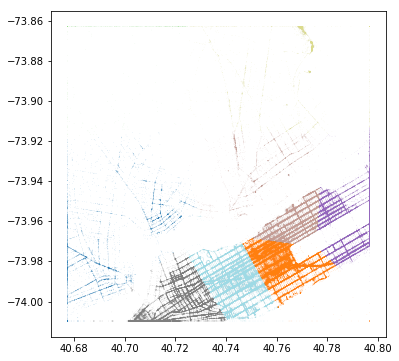

In [36]:
plt.figure(figsize=(6,6))
plt.title = "The clasters of pickup points"
plt.scatter(pickup_clusters[sample_slice,0], 
            pickup_clusters[sample_slice,1],
            c=kmeans.predict(pickup_clusters[sample_slice]), 
            s=.1, alpha=.8, lw=0, cmap='Vega20_r')

In [37]:
result['pickup_labels'] = kmeans.labels_
print(result.pickup_labels[:10])

0    6
1    0
2    6
3    2
4    4
5    0
6    3
7    4
8    0
9    0
Name: pickup_labels, dtype: int32


In [38]:
drop_columns = ['pickup_latitude', 'pickup_longitude']
result.drop(drop_columns, axis=1, inplace=True)
print(result.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2083778 entries, 0 to id0621643
Data columns (total 16 columns):
id                 object
pickup_datetime    object
trip_duration      float64
trip_distance      float64
bearing            float64
pass_1.0           uint8
pass_2.0           uint8
pass_3.0           uint8
pass_4.0           uint8
pass_5.0           uint8
pass_6.0           uint8
vendor_1           uint8
vendor_2           uint8
flag_N             uint8
flag_Y             uint8
pickup_labels      int32
dtypes: float64(3), int32(1), object(2), uint8(10)
memory usage: 203.2+ MB
None


In [39]:
result['pickup_labels'] = result.pickup_labels.astype(str)
dummies = pd.get_dummies(result['pickup_labels'], prefix="pickup")

In [40]:
dummies.head(3)

,pickup_0,pickup_1,pickup_2,pickup_3,pickup_4,pickup_5,pickup_6,pickup_7
0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0


In [41]:
result = pd.merge(result, dummies, how='inner', left_index=True, right_index=True)

In [42]:
print(result.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2083778 entries, 0 to id0621643
Data columns (total 24 columns):
id                 object
pickup_datetime    object
trip_duration      float64
trip_distance      float64
bearing            float64
pass_1.0           uint8
pass_2.0           uint8
pass_3.0           uint8
pass_4.0           uint8
pass_5.0           uint8
pass_6.0           uint8
vendor_1           uint8
vendor_2           uint8
flag_N             uint8
flag_Y             uint8
pickup_labels      object
pickup_0           uint8
pickup_1           uint8
pickup_2           uint8
pickup_3           uint8
pickup_4           uint8
pickup_5           uint8
pickup_6           uint8
pickup_7           uint8
dtypes: float64(3), object(3), uint8(18)
memory usage: 227.1+ MB
None


In [43]:
result.drop('pickup_labels', axis=1, inplace=True)

In [44]:
result['pickup_datetime'] = pd.to_datetime(result.pickup_datetime)

In [45]:
result['month'] = result['pickup_datetime'][:].dt.month

In [46]:
result['days_in_month'] = result['pickup_datetime'][:].dt.days_in_month

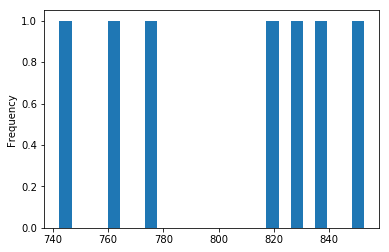

In [47]:
result['weekday'] = result['pickup_datetime'].dt.weekday_name
      
wdh = result.groupby('weekday')['trip_duration']
(wdh.mean()).plot.hist(bins=25) 

In [48]:
 df_dummie = pd.get_dummies(result['weekday'][:], prefix="weekday")

In [49]:
df_dummie.head(3)

,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0


In [50]:
result = pd.merge(result[:], df_dummie[:], how='inner', 
                         left_index=True, right_index=True)

In [51]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2083778 entries, 0 to id0621643
Data columns (total 33 columns):
id                   object
pickup_datetime      datetime64[ns]
trip_duration        float64
trip_distance        float64
bearing              float64
pass_1.0             uint8
pass_2.0             uint8
pass_3.0             uint8
pass_4.0             uint8
pass_5.0             uint8
pass_6.0             uint8
vendor_1             uint8
vendor_2             uint8
flag_N               uint8
flag_Y               uint8
pickup_0             uint8
pickup_1             uint8
pickup_2             uint8
pickup_3             uint8
pickup_4             uint8
pickup_5             uint8
pickup_6             uint8
pickup_7             uint8
month                int64
days_in_month        int64
weekday              object
weekday_Friday       uint8
weekday_Monday       uint8
weekday_Saturday     uint8
weekday_Sunday       uint8
weekday_Thursday     uint8
weekday_Tuesday      uint8
weekday_W

In [52]:
result.drop('weekday', axis=1, inplace=True)

In [53]:
result['hour'] = result['pickup_datetime'][:].dt.hour

In [54]:
result['hour'] = result.hour.astype(str)
df_dummie= pd.get_dummies(result["hour"][:], prefix="hour")
result = pd.merge(result[:], df_dummie[:], how='inner', 
                  left_index=True, right_index=True)

In [55]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2083778 entries, 0 to id0621643
Data columns (total 57 columns):
id                   object
pickup_datetime      datetime64[ns]
trip_duration        float64
trip_distance        float64
bearing              float64
pass_1.0             uint8
pass_2.0             uint8
pass_3.0             uint8
pass_4.0             uint8
pass_5.0             uint8
pass_6.0             uint8
vendor_1             uint8
vendor_2             uint8
flag_N               uint8
flag_Y               uint8
pickup_0             uint8
pickup_1             uint8
pickup_2             uint8
pickup_3             uint8
pickup_4             uint8
pickup_5             uint8
pickup_6             uint8
pickup_7             uint8
month                int64
days_in_month        int64
weekday_Friday       uint8
weekday_Monday       uint8
weekday_Saturday     uint8
weekday_Sunday       uint8
weekday_Thursday     uint8
weekday_Tuesday      uint8
weekday_Wednesday    uint8
hour      

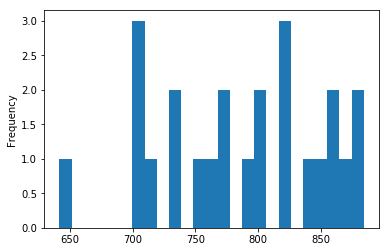

In [56]:
wdh = result.groupby('hour')['trip_duration']
(wdh.mean()).plot.hist(bins=25)

In [57]:
result.drop('hour', axis=1, inplace=True)

In [58]:
result['minute'] = result['pickup_datetime'][:].dt.minute

In [59]:
print(result.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2083778 entries, 0 to id0621643
Data columns (total 57 columns):
id                   object
pickup_datetime      datetime64[ns]
trip_duration        float64
trip_distance        float64
bearing              float64
pass_1.0             uint8
pass_2.0             uint8
pass_3.0             uint8
pass_4.0             uint8
pass_5.0             uint8
pass_6.0             uint8
vendor_1             uint8
vendor_2             uint8
flag_N               uint8
flag_Y               uint8
pickup_0             uint8
pickup_1             uint8
pickup_2             uint8
pickup_3             uint8
pickup_4             uint8
pickup_5             uint8
pickup_6             uint8
pickup_7             uint8
month                int64
days_in_month        int64
weekday_Friday       uint8
weekday_Monday       uint8
weekday_Saturday     uint8
weekday_Sunday       uint8
weekday_Thursday     uint8
weekday_Tuesday      uint8
weekday_Wednesday    uint8
hour_0    

In [60]:
result.drop('pickup_datetime', axis=1, inplace=True)

In [61]:
print(result.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2083778 entries, 0 to id0621643
Data columns (total 56 columns):
id                   object
trip_duration        float64
trip_distance        float64
bearing              float64
pass_1.0             uint8
pass_2.0             uint8
pass_3.0             uint8
pass_4.0             uint8
pass_5.0             uint8
pass_6.0             uint8
vendor_1             uint8
vendor_2             uint8
flag_N               uint8
flag_Y               uint8
pickup_0             uint8
pickup_1             uint8
pickup_2             uint8
pickup_3             uint8
pickup_4             uint8
pickup_5             uint8
pickup_6             uint8
pickup_7             uint8
month                int64
days_in_month        int64
weekday_Friday       uint8
weekday_Monday       uint8
weekday_Saturday     uint8
weekday_Sunday       uint8
weekday_Thursday     uint8
weekday_Tuesday      uint8
weekday_Wednesday    uint8
hour_0               uint8
hour_1             

In [62]:
result.to_csv('result.csv')

In [63]:
result.trip_duration.isnull().value_counts()

False    1458644
True      625134
Name: trip_duration, dtype: int64

In [64]:
# I cut off the test set with new signs.
test = result[result.trip_duration.isnull()]
test.describe()

,trip_duration,trip_distance,bearing,pass_1.0,pass_2.0,pass_3.0,pass_4.0,pass_5.0,pass_6.0,vendor_1,...,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,minute
count,0.0,625134.000000,625134.000000,625134.00000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,...,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,NaN,1.919007,-15.833621,0.70940,0.144012,0.041089,0.019223,0.053446,0.032830,0.465116,...,0.055295,0.047783,0.014207,0.010900,0.010347,0.022590,0.038101,0.046157,0.046593,29.598908
std,NaN,1.766374,104.173169,0.45404,0.351103,0.198496,0.137308,0.224922,0.178191,0.498782,...,0.228556,0.213308,0.118342,0.103833,0.101191,0.148594,0.191439,0.209824,0.210766,17.330197
min,NaN,0.380000,-180.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.760000,-124.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000
50%,NaN,1.280000,7.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000
75%,NaN,2.350000,53.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000
max,NaN,11.930000,180.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,59.000000


And training set too ...

In [65]:
train = result[result.trip_duration.notnull()]
train.describe()

,trip_duration,trip_distance,bearing,pass_1.0,pass_2.0,pass_3.0,pass_4.0,pass_5.0,pass_6.0,vendor_1,...,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,minute
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,...,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,8.043713e+02,1.921218e+00,-1.591616e+01,7.086033e-01,1.441873e-01,4.106280e-02,1.947288e-02,5.353465e-02,3.313900e-02,4.650497e-01,...,5.518276e-02,4.784238e-02,1.432495e-02,1.082649e-02,1.028489e-02,2.279377e-02,3.811759e-02,4.596941e-02,4.638760e-02,2.959016e+01
std,5.267916e+02,1.771436e+00,1.042109e+02,4.544060e-01,3.512797e-01,1.984356e-01,1.381800e-01,2.250972e-01,1.789995e-01,4.987772e-01,...,2.283367e-01,2.134327e-01,1.188266e-01,1.034857e-01,1.008916e-01,1.492455e-01,1.914802e-01,2.094188e-01,2.103231e-01,1.732471e+01
min,1.810000e+02,3.800000e-01,-1.800000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.970000e+02,7.600000e-01,-1.250000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01
50%,6.620000e+02,1.280000e+00,7.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01
75%,1.075000e+03,2.350000e+00,5.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.500000e+01
max,2.103000e+03,1.193000e+01,1.800000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.900000e+01


In [66]:
print("train.shape", train.shape, "test shape", test.shape)

train.shape (1458644, 56) test shape (625134, 56)


In [67]:
del(result)
del(x)

In [68]:
y = train['trip_duration'].values

In [69]:
train.drop(['trip_duration', 'id'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [70]:
train.head()

,trip_distance,bearing,pass_1.0,pass_2.0,pass_3.0,pass_4.0,pass_5.0,pass_6.0,vendor_1,vendor_2,...,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,minute
0,0.93,100.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,24
1,1.12,-117.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,43
2,3.96,-160.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,35
3,0.92,-176.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,32
4,0.74,179.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,30


In [71]:
X = train.values

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [73]:
print("Shape X_train: {}. Shape y_train: {}. \nShape X_test : {}. Shape y_test : {}". \
     format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Shape X_train: (1093983, 54). Shape y_train: (1093983,). 
Shape X_test : (364661, 54). Shape y_test : (364661,)


In [74]:
scaler = MinMaxScaler().fit(X_train)

In [75]:
X_train_scaled = scaler.transform(X_train)

In [76]:
print("X_train[:3]:\n{},\nX_train_scaled[:3]\n{}".    \
      format(X_train[:3], X_train_scaled[:3]))

X_train[:3]:
[[   1.34 -168.      0.      0.      0.      0.      1.      0.      0.
     1.      1.      0.      1.      0.      0.      0.      0.      0.
     0.      0.      2.     29.      0.      0.      0.      0.      0.
     0.      1.      0.      0.      0.      0.      0.      0.      0.
     0.      0.      0.      1.      0.      0.      0.      0.      0.
     0.      0.      0.      0.      0.      0.      0.      0.     56.  ]
 [   0.51  -12.      1.      0.      0.      0.      0.      0.      0.
     1.      1.      0.      1.      0.      0.      0.      0.      0.
     0.      0.      2.     29.      0.      0.      1.      0.      0.
     0.      0.      0.      0.      0.      0.      0.      0.      0.
     0.      0.      1.      0.      0.      0.      0.      0.      0.
     0.      0.      0.      0.      0.      0.      0.      0.      6.  ]
 [   1.59   62.      0.      0.      0.      0.      1.      0.      0.
     1.      1.      0.      0.      0.      

In [77]:
lr = LinearRegression()

In [78]:
lr.fit(X_train_scaled, y_train)
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print("\nAccuracy by train-scaled set: {:.3f}".   \
      format(lr.score(X_train_scaled, y_train)))

lr.coef_: [  2.81219074e+03  -2.66744412e+00  -3.67770745e+14  -3.67770745e+14
  -3.67770745e+14  -3.67770745e+14  -3.67770745e+14  -3.67770745e+14
  -2.98920531e+14  -2.98920531e+14  -4.93190725e+14  -4.93190725e+14
  -3.14791371e+14  -3.14791371e+14  -3.14791371e+14  -3.14791371e+14
  -3.14791371e+14  -3.14791371e+14  -3.14791371e+14  -3.14791371e+14
   6.75937500e+01   8.75000000e-01   5.57566264e+14   5.57566264e+14
   5.57566264e+14   5.57566264e+14   5.57566264e+14   5.57566264e+14
   5.57566264e+14   5.00028301e+13   5.00028301e+13   5.00028301e+13
   5.00028301e+13   5.00028301e+13   5.00028301e+13   5.00028301e+13
   5.00028301e+13   5.00028301e+13   5.00028301e+13   5.00028301e+13
   5.00028301e+13   5.00028301e+13   5.00028301e+13   5.00028301e+13
   5.00028301e+13   5.00028301e+13   5.00028301e+13   5.00028301e+13
   5.00028301e+13   5.00028301e+13   5.00028301e+13   5.00028301e+13
   5.00028301e+13  -7.01562500e+00]
lr.intercept_: 867104277526854.1

Accuracy by train-scale

In [79]:
X_test_scaled = scaler.transform(X_test)
print("\nAccuracy by test set: {:.3f}".   \
      format(lr.score(X_test_scaled, y_test)))


Accuracy by test set: 0.646


In [80]:
ridge = Ridge()
ridge.fit(X_train_scaled, y_train)
print("\nAccuracy by train-scaled set: {:.3f}".\
      format(ridge.score(X_train_scaled, y_train)))

print("\nAccuracy by test set: {:.3f}".\
      format(ridge.score(X_test_scaled, y_test)))


Accuracy by train-scaled set: 0.646

Accuracy by test set: 0.646


In [81]:
ridge10 = Ridge(alpha=10).fit(X_train_scaled, y_train)
print("\nAccuracy by train-scaled set: {:.3f}".\
      format(ridge10.score(X_train_scaled, y_train)))

print("\nAccuracy by test set: {:.3f}".\
      format(ridge10.score(X_test_scaled, y_test)))


Accuracy by train-scaled set: 0.646

Accuracy by test set: 0.646


In [82]:
ridge01 = Ridge(alpha=0.1).fit(X_train_scaled, y_train)
print("\nAccuracy by train-scaled set: {:.3f}".\
      format(ridge01.score(X_train_scaled, y_train)))

print("\nAccuracy by test set: {:.3f}".\
      format(ridge01.score(X_test_scaled, y_test)))


Accuracy by train-scaled set: 0.646

Accuracy by test set: 0.646


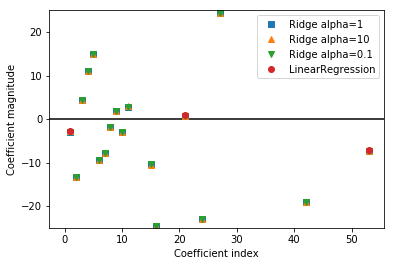

In [83]:
plt.plot(ridge.coef_, 's', label="Ridge alpha=1")
plt.plot(ridge10.coef_, '^', label="Ridge alpha=10")
plt.plot(ridge01.coef_, 'v', label="Ridge alpha=0.1")

plt.plot(lr.coef_, 'o', label="LinearRegression")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.ylim(-25, 25)
plt.legend()

We can see that the more general picture of accuracy by linear regression, it is smooth and total.

In [84]:
tree = DecisionTreeClassifier(max_depth=4)

In [85]:
tree.fit(X_train_scaled, y_train)
print("\nThe importances of features:\n {}".format(tree.feature_importances_))


The importances of features:
 [ 0.94999049  0.02403285  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.02046627  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.00551039  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]


In [86]:
for name_, score in zip(train.columns, tree.feature_importances_):
    print(name_, '.............', score)

trip_distance ............. 0.949990489527
bearing ............. 0.0240328471525
pass_1.0 ............. 0.0
pass_2.0 ............. 0.0
pass_3.0 ............. 0.0
pass_4.0 ............. 0.0
pass_5.0 ............. 0.0
pass_6.0 ............. 0.0
vendor_1 ............. 0.0
vendor_2 ............. 0.0
flag_N ............. 0.0
flag_Y ............. 0.0
pickup_0 ............. 0.0
pickup_1 ............. 0.0
pickup_2 ............. 0.0
pickup_3 ............. 0.0
pickup_4 ............. 0.0
pickup_5 ............. 0.0204662703542
pickup_6 ............. 0.0
pickup_7 ............. 0.0
month ............. 0.0
days_in_month ............. 0.0
weekday_Friday ............. 0.0
weekday_Monday ............. 0.0
weekday_Saturday ............. 0.0
weekday_Sunday ............. 0.0
weekday_Thursday ............. 0.0
weekday_Tuesday ............. 0.0
weekday_Wednesday ............. 0.0
hour_0 ............. 0.00551039296622
hour_1 ............. 0.0
hour_10 ............. 0.0
hour_11 ............. 0.0
hour_12 .......

In [87]:
X_train = X
y_train = y

In [88]:
scaler = MinMaxScaler().fit(X_train)

In [89]:
X_train_scaled = scaler.transform(X_train)

In [90]:
lr.fit(X_train_scaled, y_train)
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print("\nAccuracy by train-scaled set: {:.3f}".   \
      format(lr.score(X_train_scaled, y_train)))

lr.coef_: [  2.81326926e+03  -3.56119762e+00   6.31351699e+13   6.31351699e+13
   6.31351699e+13   6.31351699e+13   6.31351699e+13   6.31351699e+13
   3.91377582e+13   3.91377582e+13  -4.25558143e+13  -4.25558143e+13
  -4.86992694e+13  -4.86992694e+13  -4.86992694e+13  -4.86992694e+13
  -4.86992694e+13  -4.86992694e+13  -4.86992694e+13  -4.86992694e+13
   6.68828125e+01   1.21289062e+00  -3.06240994e+13  -3.06240994e+13
  -3.06240994e+13  -3.06240994e+13  -3.06240994e+13  -3.06240994e+13
  -3.06240994e+13   1.11448661e+13   1.11448661e+13   1.11448661e+13
   1.11448661e+13   1.11448661e+13   1.11448661e+13   1.11448661e+13
   1.11448661e+13   1.11448661e+13   1.11448661e+13   1.11448661e+13
   1.11448661e+13   1.11448661e+13   1.11448661e+13   1.11448661e+13
   1.11448661e+13   1.11448661e+13   1.11448661e+13   1.11448661e+13
   1.11448661e+13   1.11448661e+13   1.11448661e+13   1.11448661e+13
   1.11448661e+13  -7.47656250e+00]
lr.intercept_: 8461388950158.762

Accuracy by train-scale

In [91]:
X_test = test.drop(['trip_duration', 'id'], axis=1).values

In [92]:
print(X_test.shape)

(625134, 54)


In [93]:
X_test_scaled = scaler.transform(X_test)

In [94]:
y_pred = lr.predict(X_test_scaled)

In [95]:
print(y_pred)

[  762.29296875   452.58203125   541.70703125 ...,  1503.38085938
  2114.7421875   1183.921875  ]


In [96]:
submission = pd.read_csv('../input/sample_submission.csv', index_col=0, header=0)

In [97]:
submission.head()

,trip_duration
id,
id3004672,959
id3505355,959
id1217141,959
id2150126,959
id1598245,959


In [98]:
submission.shape

(625134, 1)

In [99]:
y_pred.shape

(625134,)

In [100]:
submission.trip_duration = y_pred
submission.head(20)

,trip_duration
id,
id3004672,762.292969
id3505355,452.582031
id1217141,541.707031
id2150126,1083.207031
id1598245,427.160156
id0668992,978.910156
id1765014,875.339844
id0898117,792.277344
id3905224,2366.333984


In [101]:
submission.describe()

,trip_duration
count,625134.000000
mean,804.146612
std,422.418026
min,-127.398438
25%,542.865723
50%,679.113770
75%,921.513428
max,3296.755859


In [102]:
submission.to_csv('submission.csv')

In [103]:
def plot_feature_importances_taxi(model):
    n_features = train.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, 
             align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Importance of feature")
    plt.ylabel("Feature") 

In [104]:
tree = DecisionTreeClassifier(max_depth=12)
tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

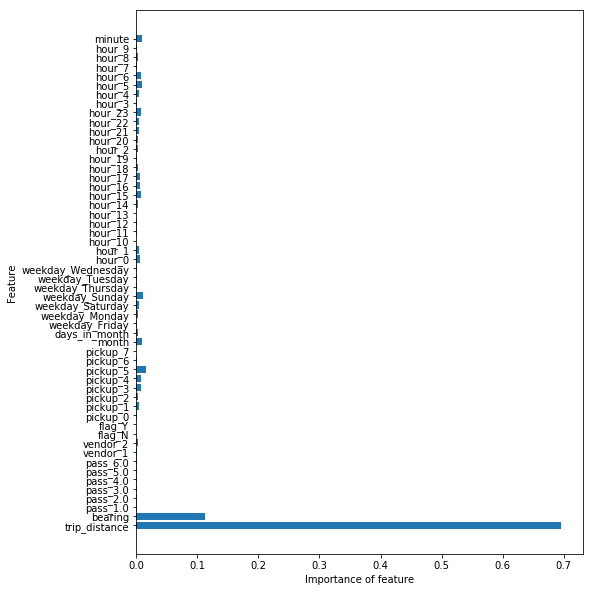

In [105]:
plot_feature_importances_taxi(tree)